## Xenium sensitivity and specificity analysis

### Relative per-gene sensitivity between two samples

This task compares the sensitivity of two samples obtained with different panels (Xenium Prime 5K relative to Xenium v1).

| Sample  | Panel | Organ | Disease |
|---------|-------|-------|---------|
| TENX143 | Xenium Human 5K Pan Tissue and Pathways Panel | Lymphoid | Diseased (Reactive Lymph Node) |
| TENX125 | Xenium Human Multi-Tissue and Cancer Panel (V1) | Lymphoid | Diseased (Reactive follicular hyperplasia) |
| TENX158 | Xenium Human 5K Pan Tissue and Pathways Panel | Skin | Cancer (Primary Dermal Melanoma) |
| TENX115 | Xenium Human Skin Gene Expression Panel (V1) | Skin | Cancer (SKCM) |

Compare same-organ samples to have enough genes in common.

13:56:44 | INFO | Found 6550 unknown genes out of 11094
13:56:44 | INFO | Mapped 9 aliases to their parent name, 6541 remaining unknown genes


/home/mdlab1/miniconda3/envs/hest/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:432: RuntimeWarning: invalid value encountered in divide
  return values / sums[:, None]


13:56:45 | INFO | Found 170 unknown genes out of 541
13:56:45 | INFO | Mapped 1 aliases to their parent name, 169 remaining unknown genes
Number of Common Genes:  217


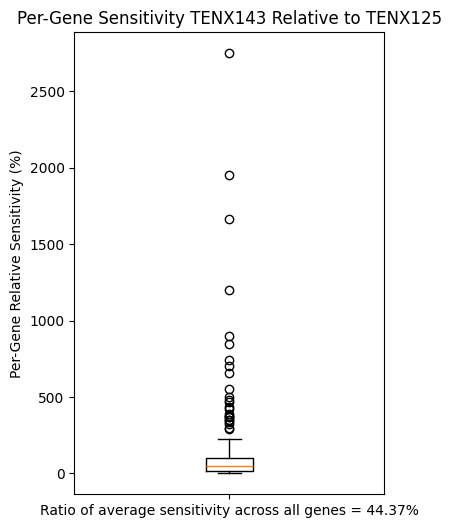

In [5]:
from hest.HESTData import iter_hest, unify_gene_names
from hest.sensitivity import find_common_genes, filter_adata_by_gene_names, paired_sensitivity

ids_to_query = ['TENX143', 'TENX125']

adata_list = []
for st in iter_hest('../hest_data', id_list=ids_to_query):
    unified_adata = unify_gene_names(st.adata)
    adata_list.append(unified_adata)

common_genes = find_common_genes(adata_list)
if len(common_genes) > 0:
    print('Number of Common Genes: ', len(common_genes))
else:
    raise ValueError('No common genes found between the datasets')

adata_filtered_1 = filter_adata_by_gene_names(adata_list[0], common_genes)
adata_filtered_2 = filter_adata_by_gene_names(adata_list[1], common_genes)

per_gene_ratio, per_sample_ratio = paired_sensitivity(adata_filtered_1, adata_filtered_2)

import matplotlib.pyplot as plt
subtitle = f'Ratio of average sensitivity across all genes = {per_sample_ratio*100:.2f}%'
plt.figure(figsize=(4, 6))
plt.boxplot(per_gene_ratio * 100, tick_labels=[subtitle])
plt.title(f'Per-Gene Sensitivity {ids_to_query[0]} Relative to {ids_to_query[1]}')
plt.ylabel('Per-Gene Relative Sensitivity (%)')
plt.show()

### False Positive Rate

Two metrics are proposed:
- **Negative Control Codeword Rate (NCCR)**: false positive rate of the decoding algorithm adjusted to the proportion of negative control codewords in the panel.
- **Negative Control Probe Rate (NCPR)**: false positive rate of the transcript signal adjusted to the proportion of probes that are negative control probes in the panel.

In [2]:
from hest.HESTData import XeniumHESTData

for st in iter_hest('../hest_data', id_list=ids_to_query):
    # Convert HESTData to XeniumHESTData
    xenium_st = XeniumHESTData(st.adata, st.wsi, st.pixel_size)
    
    print('False Positive Rate Metrics for', st.meta['id'])
    nccr = xenium_st.compute_negative_control_codeword_rate()
    ncpr = xenium_st.compute_negative_control_probe_rate()
    print(f'Negative Control Codeword Rate: {nccr*100:.2f}%')
    print(f'Negative Control Probe Rate: {ncpr*100:.2f}%')
    print()

False Positive Rate Metrics for TENX143
Negative Control Codeword Rate: 0.24%
Negative Control Probe Rate: 0.32%

False Positive Rate Metrics for TENX125
Negative Control Codeword Rate: 0.93%
Negative Control Probe Rate: 0.79%



/home/mdlab1/miniconda3/envs/hest/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:432: RuntimeWarning: invalid value encountered in divide
  return values / sums[:, None]
/home/mdlab1/miniconda3/envs/hest/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:432: RuntimeWarning: invalid value encountered in divide
  return values / sums[:, None]


### Using raw transcript data

Using raw transcript data one can filter high quality (Phred quality score >= 20) transcripts.

In [3]:
import pandas as pd

for st in iter_hest('../hest_data', id_list=ids_to_query):
    # Load transcripts efficiently and filter low quality transcripts
    sample_id = st.meta['id']
    parquet_file = f'../hest_data/transcripts/{sample_id}_transcripts.parquet'
    transcript_df = pd.read_parquet(parquet_file, columns=['feature_name', 'qv'])
    transcript_df = transcript_df[transcript_df['qv'] >= 20][['feature_name']]

    # Convert HESTData to XeniumHESTData
    xenium_st = XeniumHESTData(st.adata, st.wsi, st.pixel_size)
    xenium_st.transcript_df = transcript_df

    print('False Positive Rate Metrics for', sample_id)
    nccr = xenium_st.compute_negative_control_codeword_rate()
    ncpr = xenium_st.compute_negative_control_probe_rate()
    print(f'Negative Control Codeword Rate: {nccr*100:.2f}%')
    print(f'Negative Control Probe Rate: {ncpr*100:.2f}%')
    print()

False Positive Rate Metrics for TENX143
Negative Control Codeword Rate: 0.01%
Negative Control Probe Rate: 0.06%



/home/mdlab1/miniconda3/envs/hest/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:432: RuntimeWarning: invalid value encountered in divide
  return values / sums[:, None]
/home/mdlab1/miniconda3/envs/hest/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:432: RuntimeWarning: invalid value encountered in divide
  return values / sums[:, None]


False Positive Rate Metrics for TENX125
Negative Control Codeword Rate: 0.03%
Negative Control Probe Rate: 0.15%

